<a href="https://colab.research.google.com/github/vk1996/fullgradsaliency_TF1.0/blob/master/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/vk1996/fullgradsaliency_TF1.0.git

Cloning into 'fullgradsaliency_TF1.0'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 42 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [2]:
import os
os.chdir('/content/fullgradsaliency_TF1.0')
## use wget to download imagenet label file
!wget https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

--2019-12-18 22:04:07--  https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30564 (30K) [text/plain]
Saving to: ‘imagenet1000_clsidx_to_labels.txt’

imagenet1000_clsidx 100%[===================>]  29.85K  --.-KB/s    in 0.01s   

2019-12-18 22:04:07 (2.85 MB/s) - ‘imagenet1000_clsidx_to_labels.txt’ saved [30564/30564]



In [4]:
%tensorflow_version 1.0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from matplotlib import pyplot as plt 
from tensorflow.keras import backend as K
import numpy as np
import cv2
from fullgrad import *
from glob import glob
import ast

with open('/content/fullgradsaliency_TF1.0/imagenet1000_clsidx_to_labels.txt') as imagenet_classes_file:
    imagenet_classes_dict = ast.literal_eval(imagenet_classes_file.read())

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.0`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [5]:
K.clear_session()
model=ResNet50(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
102973440/102967424 [==============================] - 1s 0us/step


In [0]:
fullgrad=Fullgrad(model)
fullgrad_model=fullgrad.create_fullgradmodel()

In [0]:
img_path = '/content/fullgradsaliency_TF1.0/sample_img/2007_000256.jpg'
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
preprocessed_input=preprocess_input(x)

In [0]:
cam,maxclass=fullgrad.saliency(preprocessed_input)

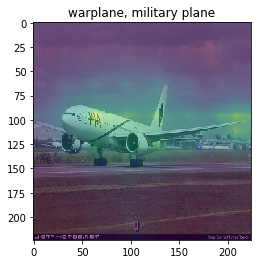

In [12]:
plt.title(imagenet_classes_dict[maxclass])
plt.imshow(img)
plt.imshow(cam,alpha=0.5)
plt.show()